In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
!pip install xgboost

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [4]:
train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

# Data Description

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Preview 

In [5]:
def check_df(dataframe, head=5):
    print("                      Shape                      ")
    print(dataframe.shape)
    print("                      Types                      ")
    print(dataframe.info())
    print("                      Head                      ")
    print(dataframe.head(head))
    print("                      Tail                      ")
    print(dataframe.tail(head))
    print("                      NA                      ")
    print(dataframe.isnull().sum())
    print("                      NA (%)                      ")
    print((train_df.isna().sum() / len(train_df)).round(4) * 100)
    print("                      Quantiles                      ")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(train_df)

                      Shape                      
(8693, 14)
                      Types                      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
                      Head

# Visual checks

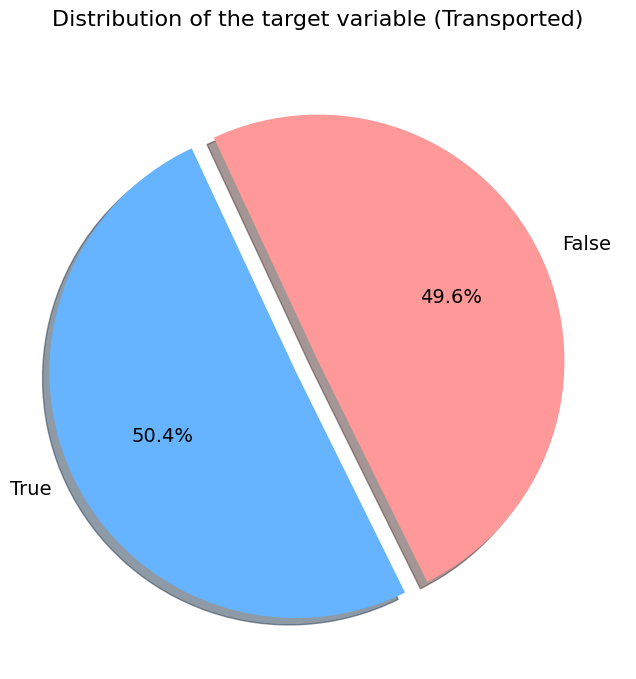

In [7]:
data_pie = train_df['Transported'].value_counts().reset_index()
data_pie.columns = ['Transported', 'Count'] 

plt.figure(figsize=(10, 8))
plt.pie(
    data_pie['Count'],
    labels=data_pie['Transported'],  
    autopct='%1.1f%%',
    startangle=115,
    colors=['#66b3ff', '#ff9999'],
    explode=(0.1, 0),
    shadow=True,
    textprops={'fontsize': 14}
)

plt.title('Distribution of the target variable (Transported)', fontsize=16, pad=20)

plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Age', ylabel='Count'>

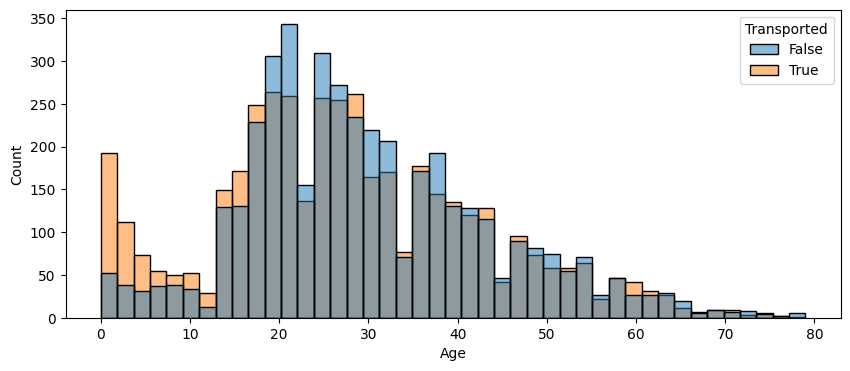

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(data=train_df, x='Age', hue='Transported')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='RoomService', ylabel='Count'>

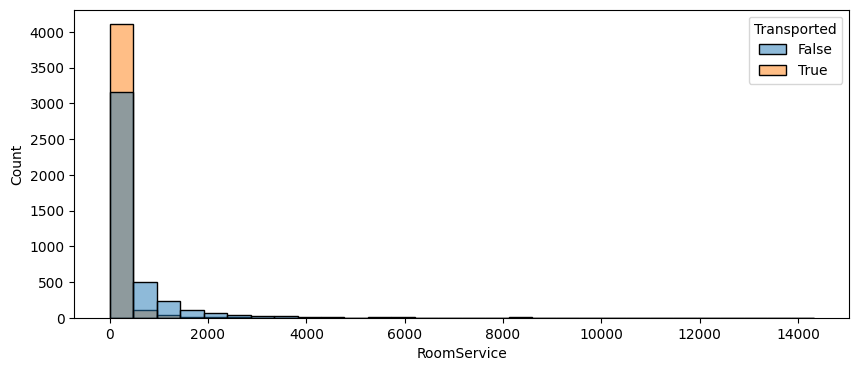

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data=train_df, x='RoomService', hue='Transported', bins=30)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Spa', ylabel='Count'>

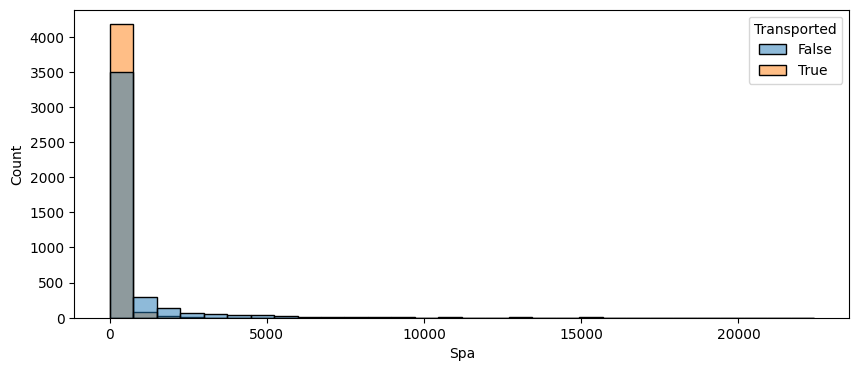

In [10]:
plt.figure(figsize=(10,4))
sns.histplot(data=train_df, x='Spa', hue='Transported', bins=30)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='ShoppingMall', ylabel='Count'>

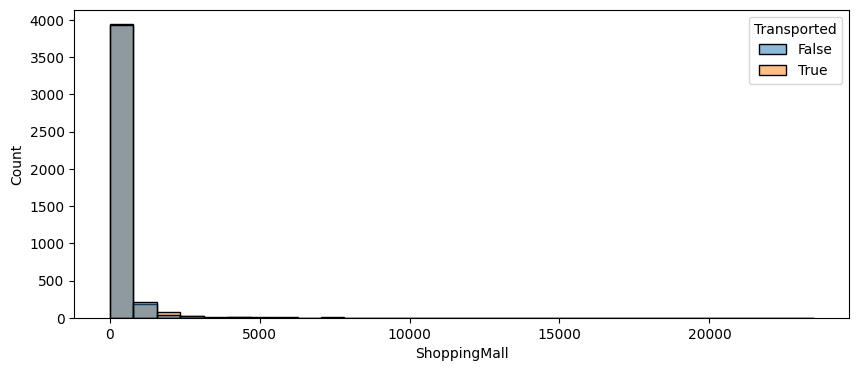

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(data=train_df, x='ShoppingMall', hue='Transported', bins=30)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Spa', ylabel='Count'>

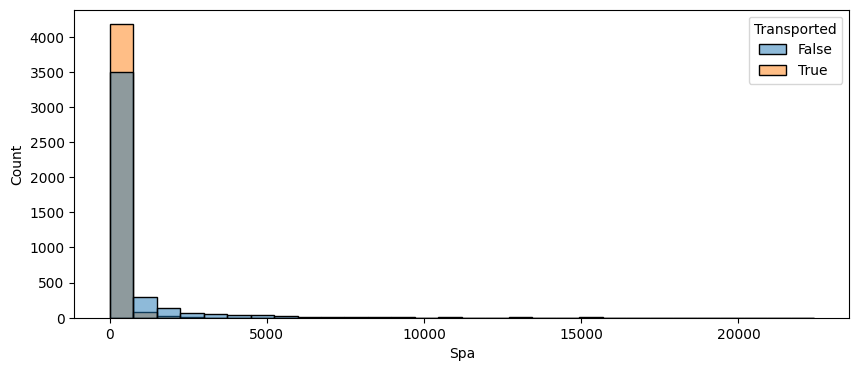

In [12]:
plt.figure(figsize=(10,4))
sns.histplot(data=train_df, x='Spa', hue='Transported', bins=30)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='VRDeck', ylabel='Count'>

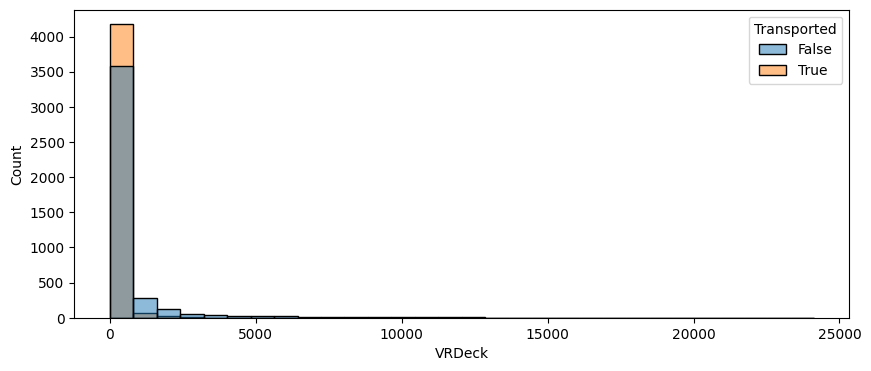

In [13]:
plt.figure(figsize=(10,4))
sns.histplot(data=train_df, x='VRDeck', hue='Transported', bins=30)

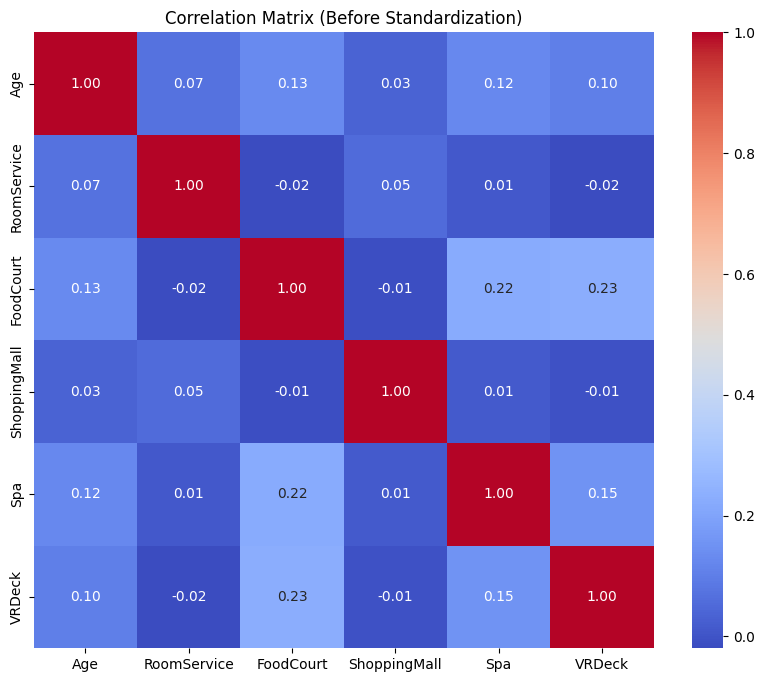

In [14]:
numeric_df = train_df.select_dtypes(include=['number'])

corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Before Standardization)")
plt.show()

# Cleaning Data

In [15]:
def preprocess_data(data, is_train=True):
    data = data.copy()
    data.drop(columns=['Name', 'Cabin'], inplace=True)

    data.dropna(how='all', inplace=True)

    imputer = SimpleImputer(strategy='most_frequent')
    data.iloc[:, :] = imputer.fit_transform(data)

    categorical_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']
    numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ])

    data_processed = preprocessor.fit_transform(data)

    feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
    data_processed = pd.DataFrame(data_processed, columns=feature_names)

    if is_train:
        X = data_processed
        y = data['Transported'].astype(int)
        return X, y
    else:
        return data_processed

In [16]:
X, y = preprocess_data(train_df, is_train=True)
X_test = preprocess_data(test_df, is_train=False)

# Model training

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=250,
    early_stopping_rounds=5,
    learning_rate=0.10,
    colsample_bytree=0.70,
    max_depth=3,
    n_jobs=4
)

# Обучение модели
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=4,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
predictions = xgb_model.predict(X_valid)

In [20]:
# Оценка точности
accuracy = accuracy_score(y_valid, predictions)
train_score = round(xgb_model.score(X_train, y_train) * 100, 2)
valid_score = round(xgb_model.score(X_valid, y_valid) * 100, 2)

print('Accuracy: ', round(accuracy * 100, 2), '%', sep='')

Accuracy: 78.44%


# Confusion Matrix

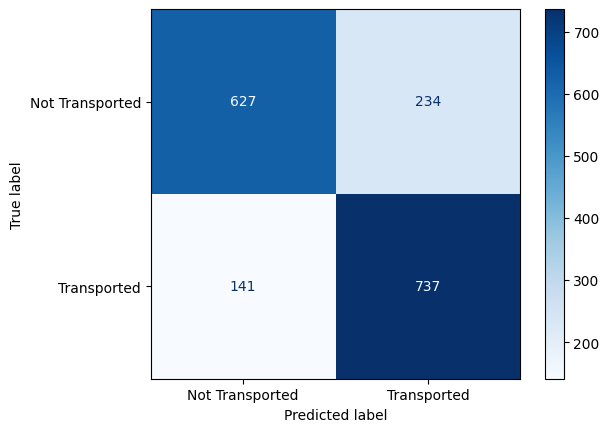

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix generation
cm = confusion_matrix(y_valid,predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ['Not Transported', 'Transported'])
disp.plot(cmap = 'Blues')

# Feature Importance 

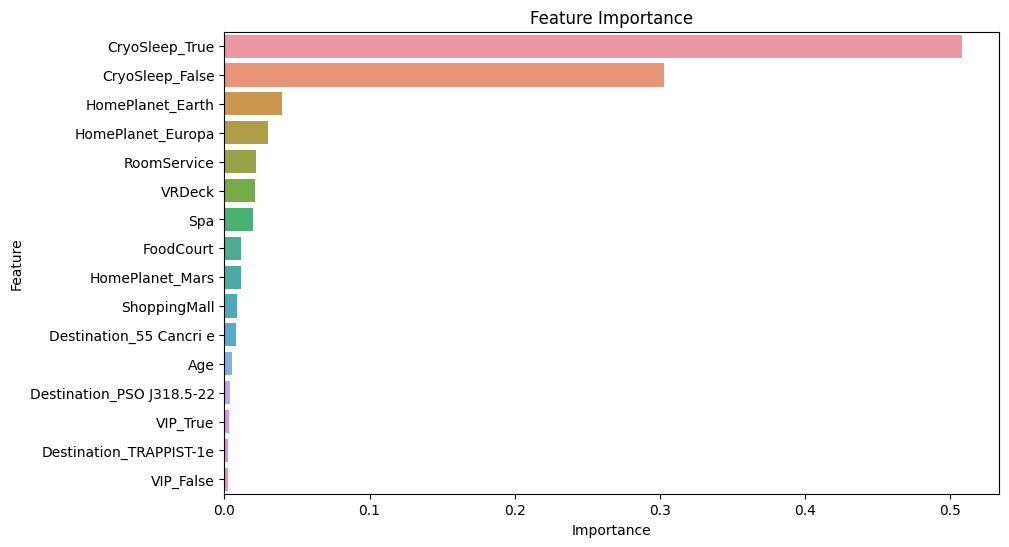

In [22]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 
                                   'Importance': xgb_model.feature_importances_})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


# Submission

In [23]:
test_predictions = xgb_model.predict(X_test)

submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': test_predictions.astype(bool)})
submission.to_csv('my_submission.csv', index=False)

print("Submission file saved my_prediction.csv")
submission.head()

Submission file saved my_prediction.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [24]:
submission.to_csv("my_submission.csv", index = False)